In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Estudio de consumo de frutas y vegetales por paises de la Unión Europea

## Paso 1: importado de datos CSV

In [15]:
#IMPORTAR CSV
df=pd.read_csv("Data/daily_consumption_fruit_vegetables_eu.csv")
print('Forma del Dataframe: ',df.shape)
print('Tamaño del Dataframe: ',df.size)

Forma del Dataframe:  (43488, 7)
Tamaño del Dataframe:  304416


In [16]:
#ESCRIBIR CABECERA (5 ROWS)
df.head()

,unit,n_portion,sex,age,country,time,value
0,PC,0,F,TOTAL,AT,2019,29.1
1,PC,0,F,TOTAL,BE,2019,17.1
2,PC,0,F,TOTAL,BG,2019,54.2
3,PC,0,F,TOTAL,CY,2019,32.7
4,PC,0,F,TOTAL,CZ,2019,49.6


### Extraemos solo los datos necesarios para nuestro estudio. En este caso, los datos del año 2019(el último)

In [66]:
#EXTRAER EL ÚLTIMO AÑO
ultimoAnio=df["time"].max()
print("año:",ultimoAnio)
df_LastYear=df[df["time"]==ultimoAnio]
print('Forma del Dataframe: ',df_LastYear.shape)
print('Tamaño del Dataframe: ',df_LastYear.size)


año: 2019
Forma del Dataframe:  (21744, 7)
Tamaño del Dataframe:  152208


In [18]:
df_LastYear.head()

,unit,n_portion,sex,age,country,time,value
0,PC,0,F,TOTAL,AT,2019,29.1
1,PC,0,F,TOTAL,BE,2019,17.1
2,PC,0,F,TOTAL,BG,2019,54.2
3,PC,0,F,TOTAL,CY,2019,32.7
4,PC,0,F,TOTAL,CZ,2019,49.6


## Paso 2: Limpieza de datos

### Limpieza previa de tipos

In [19]:
#DESCRIBO EL DATAFRAME PARA LIMPIAR CORRECTAMENTE POR COLUMNAS
df_LastYear.info()
print('columnas del DataFrame:',df_LastYear.columns)

#LIMPIEZA PREVIA DE TIPOS
df["country"] = df["country"].astype(str).str.strip()
df["sex"] = df["sex"].astype(str).str.strip()
df["time"] = df["time"].astype(str).str.strip()
df["value"] = pd.to_numeric(df["value"], errors="coerce")

<class 'pandas.core.frame.DataFrame'>
Index: 21744 entries, 0 to 21743
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   unit       21744 non-null  object 
 1   n_portion  21744 non-null  object 
 2   sex        21744 non-null  object 
 3   age        21744 non-null  object 
 4   country    21744 non-null  object 
 5   time       21744 non-null  int64  
 6   value      14841 non-null  float64
dtypes: float64(1), int64(1), object(5)
memory usage: 1.3+ MB
columnas del DataFrame: Index(['unit', 'n_portion', 'sex', 'age', 'country', 'time', 'value'], dtype='object')


### Limpieza profunda de datos: rellenar nulos, eliminar datos innecesarios o que distorsionen...etc

In [67]:
#VERIFICO QUE NO HAY PAISES EXTRAÑOS O GRUPOS DE PAISES
print('Valores de country en DataFrame original:',df["country"].unique())

# Eliminar agregaciones de la UE
paises_a_eliminar = ["EU28", "EU27_2020"]
df_limpio = df_LastYear[~df_LastYear["country"].isin(paises_a_eliminar)]

print('Países en DataFrame limpio:',df_limpio["country"].unique())
print("_"*50)

#VERIFICO LOS VALORES DE SEXO
print('Valores de sexo en DataFrame original:',df["sex"].unique())
df_limpio = df_limpio[df_limpio["sex"].isin(["F", "M"])]
print('Valores de sexo en DataFrame limpio:',df_limpio["sex"].unique())
print("_"*50)

#COMPROBAMOS QUE LOS RANGOS DE EDAD SON CORRECTOS
print('Valores de age en DataFrame original:',df["age"].unique())

import re
pattern = r"^Y\d{1,3}-\d{1,3}$"   
mask_edades = df_limpio["age"].str.match(pattern, na=False)

#FILTRAR Y VER
df_limpio = df_limpio[mask_edades].copy()
print("Edades únicas después:",(df_limpio["age"].unique()))

elegidos = ["Y15-24","Y25-34","Y35-44","Y45-54","Y45-64"]
df_limpio = df_limpio[df_limpio["age"].isin(elegidos)].copy()
print('Rangos elegidos de edad:',df_limpio["age"].unique())


print("_"*50)

#EL PRIMER PROBLEMA QUE OBSERVO, ES QUE HAY "value" VACIOS, relleno con la media.
#luego veo que hay ceros, que también los voy a reemplazar por la media.
#Para mayor precisión, lo hago con la media global, no con la de año.

#ANALIZO VALORES NULOS Y CEROS Y REEMPLAZO LOS ZEROS POR NAN PARA NO INFLUIR EN LA MEDIA
print('Cantidad de valores nulos en el dataframe original:',df_LastYear["value"].isna().replace(0,np.nan).sum())
print('Cantidad de ceros en el dataframe original:',(df_LastYear["value"]==0).sum())
print("_"*50)

#CALCULO LA MEDIA GLOBAL
media_valor=df_limpio["value"].mean().round(1)
print('La media global de valor de consumo es:',media_valor)
print("_"*50)

#REEMPLAZO VALORES NULOS Y CEROS POR LA MEDIA GLOBAL
#df_limpio = df_LastYear.copy()
df_limpio["value"] = df_limpio["value"].fillna(media_valor)
# Reemplazar ceros por la media por país

def calcular_media_sin_ceros(grupo):
    """Calcula la media excluyendo los ceros"""
    return grupo[grupo != 0].mean()

media_por_pais = df_limpio.groupby("country")["value"].transform(calcular_media_sin_ceros)
df_limpio.loc[df_limpio["value"]==0, "value"] = media_por_pais

print('Cantidad de valores nulos actualizada:',df_limpio["value"].isna().sum())
print('Cantidad de ceros actualizada:',(df_limpio["value"]==0).sum())
print("_"*50)





Valores de country en DataFrame original: ['AT' 'BE' 'BG' 'CY' 'CZ' 'DE' 'DK' 'EE' 'EL' 'ES' 'EU27_2020' 'EU28' 'FI'
 'FR' 'HR' 'HU' 'IE' 'IS' 'IT' 'LT' 'LU' 'LV' 'MT' 'NL' 'NO' 'PL' 'PT'
 'RO' 'RS' 'SE' 'SI' 'SK' 'TR' 'UK']
Países en DataFrame limpio: ['AT' 'BE' 'BG' 'CY' 'CZ' 'DE' 'DK' 'EE' 'EL' 'ES' 'FI' 'FR' 'HR' 'HU'
 'IE' 'IS' 'IT' 'LT' 'LU' 'LV' 'MT' 'NL' 'NO' 'PL' 'PT' 'RO' 'RS' 'SE'
 'SI' 'SK' 'TR' 'UK']
__________________________________________________
Valores de sexo en DataFrame original: ['F' 'M' 'T']
Valores de sexo en DataFrame limpio: ['F' 'M']
__________________________________________________
Valores de age en DataFrame original: ['TOTAL' 'Y15-19' 'Y15-24' 'Y15-29' 'Y15-44' 'Y15-64' 'Y20-24' 'Y25-29'
 'Y25-34' 'Y25-64' 'Y35-44' 'Y45-54' 'Y45-64' 'Y55-64' 'Y65-74' 'Y_GE18'
 'Y_GE65' 'Y_GE75']
Edades únicas después: ['Y15-19' 'Y15-24' 'Y15-29' 'Y15-44' 'Y15-64' 'Y20-24' 'Y25-29' 'Y25-34'
 'Y25-64' 'Y35-44' 'Y45-54' 'Y45-64' 'Y55-64' 'Y65-74']
Rangos elegidos de edad: [

## Paso 3: análisis

### Muestra de promedio de consumo en gramos por país

In [28]:
#UNA VEZ LIMPIO, PRETENDO MOSTRAR UN RESUMEN DE MEDIA POR PAIS

df_resumen=df_limpio.groupby("country")["value"].mean().reset_index()
df_resumen.set_index("country", inplace=True)
df_resumen.sort_values(by="value", ascending=False, inplace=True)   
print('Resumen de los primeros cinco paises con mayor consumo diario de frutas y verduras:')
print(df_resumen.head())
print("_"*50)
print('Resumen de los últimos cinco paises con menor consumo diario de frutas y verduras:')
print(df_resumen.tail())

Resumen de los primeros cinco paises con mayor consumo diario de frutas y verduras:
             value
country           
SK       34.777391
CZ       33.896610
PL       33.895763
SI       33.894068
RO       33.620168
__________________________________________________
Resumen de los últimos cinco paises con menor consumo diario de frutas y verduras:
             value
country           
EE       33.329167
DK       33.329167
BE       33.329167
LU       33.329167
UK       33.300000


## Paso 4: comunicación de datos y visualización

### Mostramos gráficos de consumo por país

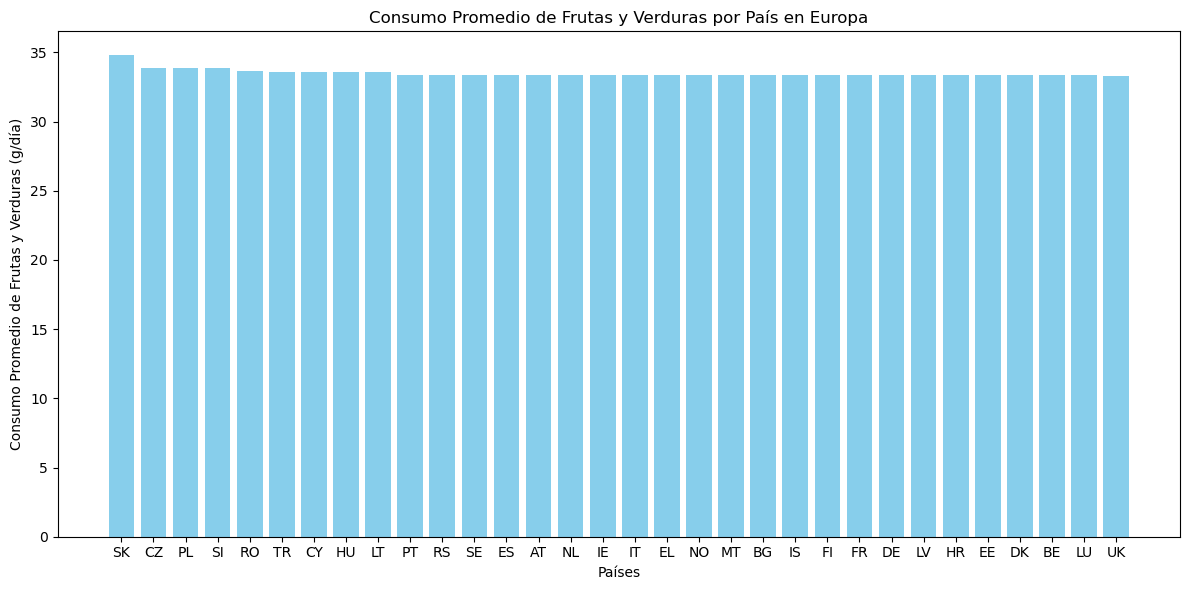

In [55]:
#MUESTRO UN GRÁFICO PARA VER MEJOR LA DIFERENCIA ENTRE PAÍSES

paises = df_resumen.index
consumo = df_resumen["value"]

plt.figure(figsize=(12, 6))
plt.bar(paises, consumo, color='skyblue')
plt.xlabel('Países')
plt.ylabel('Consumo Promedio de Frutas y Verduras (g/día)')
plt.title('Consumo Promedio de Frutas y Verduras por País en Europa')
plt.tight_layout()
plt.show()


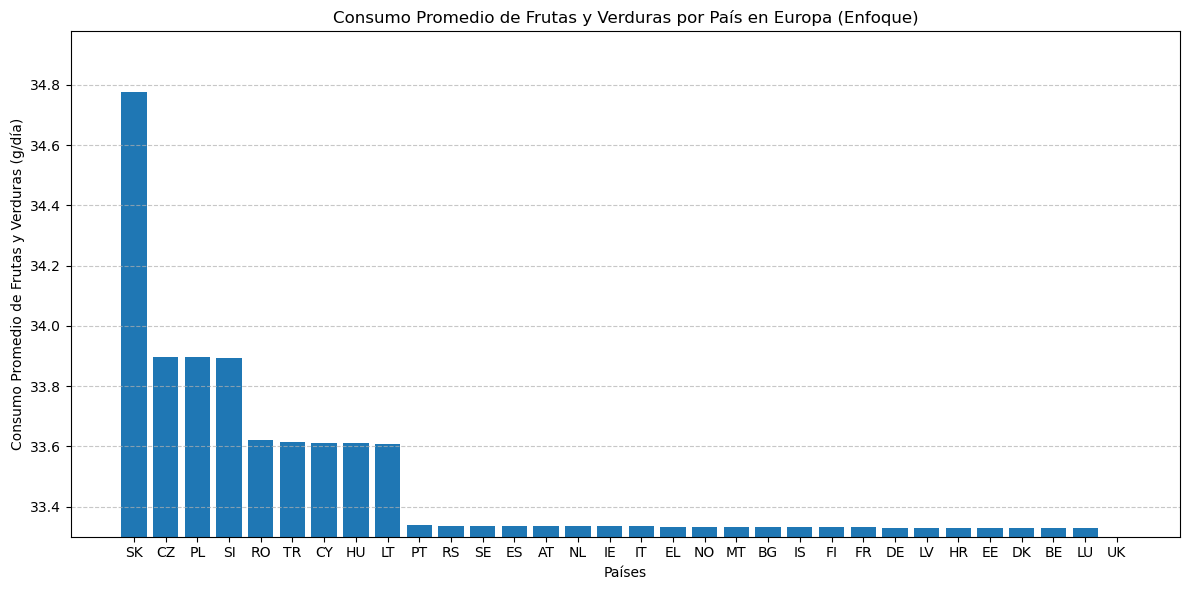

In [60]:
#OTRO GRÁFICO DE BARRAS CON LÍMITES MÁS JUSTOS
plt.figure(figsize=(12, 6))
plt.bar(paises, consumo)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.ylim(np.min(consumo), np.max(consumo)+0.2)  # Ajusta los límites del eje y para enfocarte en el rango relevante
plt.xlabel('Países')    
plt.ylabel('Consumo Promedio de Frutas y Verduras (g/día)')
plt.title('Consumo Promedio de Frutas y Verduras por País en Europa (Enfoque)')
plt.tight_layout()      
plt.show()

### Analizamos el sexo en relación al consumo y mostramos gráfico

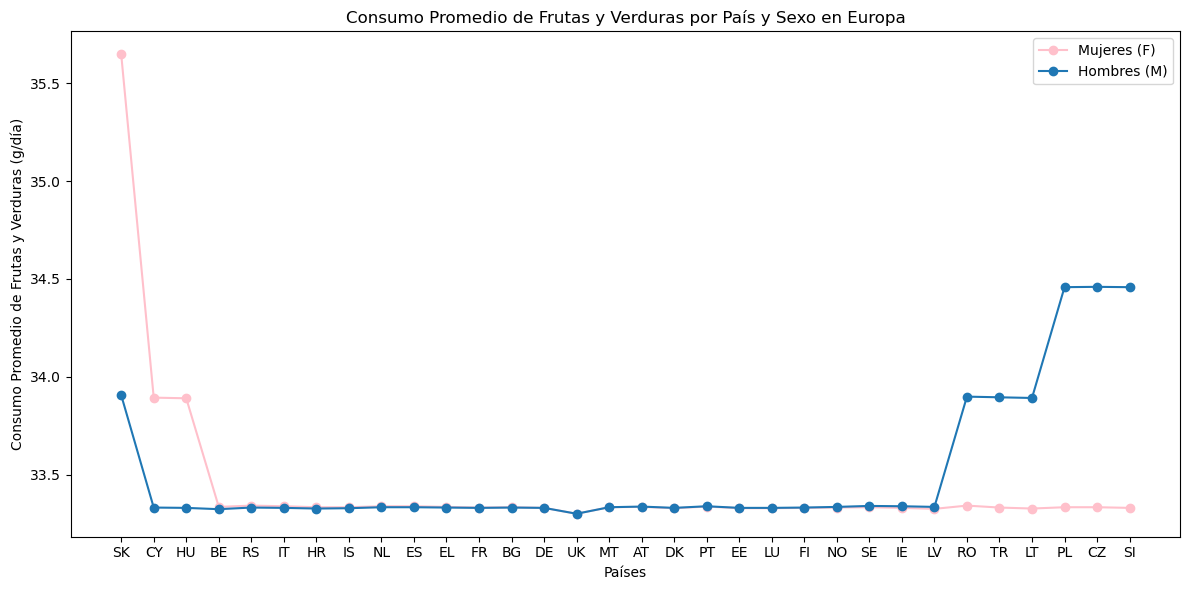

In [30]:
#AHORA QUIERO VER LA DIFERENCIA ENTRE SEXOS EN CADA PAÍS
#AGRUPO POR SEXOS Y DESPUÉS HAGO UN PIVOT PARA TENERLOS EN COLUMNAS
df_sexo = df_limpio.groupby(["country","sex"])["value"].mean().reset_index()
df_sexo_pivot = df_sexo.pivot(index="country", columns="sex", values="value")
df_sexo_pivot["diferencia"] = df_sexo_pivot.get("F", pd.Series(dtype=float)) - df_sexo_pivot.get("M", pd.Series(dtype=float))
df_sexo_pivot.sort_values(by="diferencia", ascending=False, inplace=True)

#EXTRAIGO ARRAYS PARA EL GRÁFICO
f = df_sexo_pivot["F"]
m = df_sexo_pivot["M"]

paises = df_sexo_pivot.index
x = np.arange(len(paises))

plt.figure(figsize=(12, 6))
plt.plot(x, f, label='Mujeres (F)', marker='o', color='pink')
plt.plot(x, m, label='Hombres (M)', marker='o')
plt.xticks(x, paises)
plt.title('Consumo Promedio de Frutas y Verduras por País y Sexo en Europa')
plt.xlabel('Países')
plt.ylabel('Consumo Promedio de Frutas y Verduras (g/día)')
plt.legend()

plt.tight_layout()
plt.show()


### Análisis de consumo por rangos de edades

In [42]:
#VAMOS A HACER UN ANÁLISIS POR EDADES TAMBIÉN
df_edad = df_limpio.groupby(["age"])["value"].mean()
print(df_edad.head())


age
Y15-24    33.507024
Y25-34    33.464304
Y35-44    33.597853
Y45-54    33.464836
Y45-64    33.332812
Name: value, dtype: float64


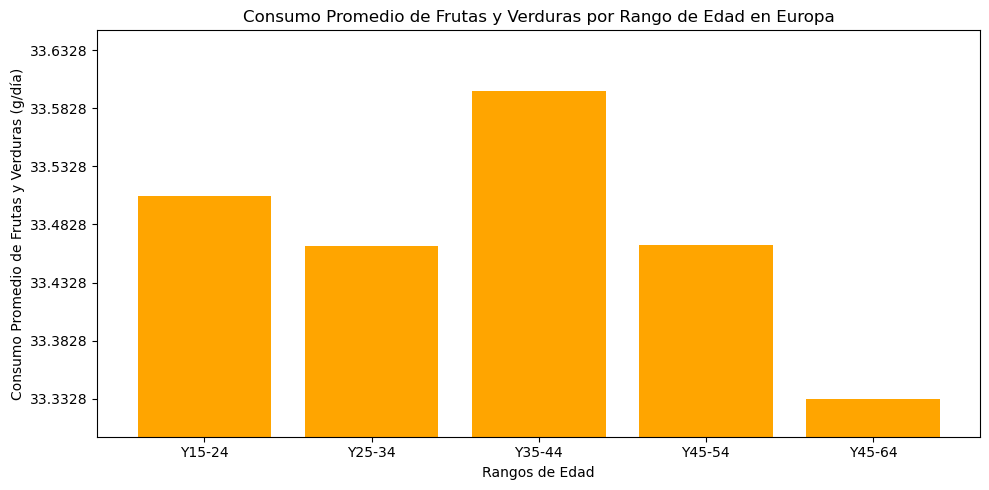

In [ ]:
#GRAFICO DE BARRAS PARA ANALIZAR POR RANGOS DE EDADES
rangos_edad=df_edad.index
consumo_edad=df_edad.values

# Incrementos de 0.05 para máxima granularidad
yticks = np.arange(min(consumo_edad), max(consumo_edad) + 0.05, 0.05)

plt.figure(figsize=(10, 5))
#limites más justos para ver mejor la diferencia
plt.ylim(33.3, 33.65)
plt.bar(rangos_edad, consumo_edad, color='orange')
plt.xlabel('Rangos de Edad')
plt.ylabel('Consumo Promedio de Frutas y Verduras (g/día)') 
plt.title('Consumo Promedio de Frutas y Verduras por Rango de Edad en Europa')
plt.yticks(yticks)
plt.tight_layout()
plt.show()

## Paso extra: preparación de datos para uso de compañeros

### Aquí escribo un resumen de los dataframes y series utilizados en limpio para facilitar la extracción de los mismos por parte de mis compañeros

In [64]:
#DATAFRAMES EXTRAIDOS
df_final=df_limpio.copy()
df_paises = df_resumen.copy()
df_sexos = df_sexo_pivot.copy()
df_edades = df_edad.copy()
#_______________________________________________________________________________________
print('RESUMEN DE DATAFRAMES EXTRAIDOS:')
print("-"*50)

print("DATAFRAME LIMPIO:")
print(df_final.head())
print("_"*50)

print("VALORES EN GRAMOS DE CONSUMO PROMEDIO POR PAÍS:")
print(df_paises.head())
print("_"*50)

print("VALORES EN GRAMOS DE CONSUMO PROMEDIO POR SEXO Y PAÍS:")
print(df_sexos.head())
print("_"*50)

print("VALORES EN GRAMOS DE CONSUMO PROMEDIO POR RANGO DE EDAD:")
print(df_edades.head())
print("_"*50)

RESUMEN DE DATAFRAMES EXTRAIDOS:
--------------------------------------------------
DATAFRAME LIMPIO:
   unit n_portion sex     age country  time  value
66   PC         0   F  Y15-24      AT  2019   37.6
67   PC         0   F  Y15-24      BE  2019   23.5
68   PC         0   F  Y15-24      BG  2019   43.9
69   PC         0   F  Y15-24      CY  2019   39.3
70   PC         0   F  Y15-24      CZ  2019   42.2
__________________________________________________
VALORES EN GRAMOS DE CONSUMO PROMEDIO POR PAÍS:
             value
country           
SK       34.777391
CZ       33.896610
PL       33.895763
SI       33.894068
RO       33.620168
__________________________________________________
VALORES EN GRAMOS DE CONSUMO PROMEDIO POR SEXO Y PAÍS:
sex              F          M  diferencia
country                                  
SK       35.648493  33.906290    1.742203
CY       33.893543  33.331667    0.561877
HU       33.890168  33.330000    0.560168
BE       33.335000  33.323333    0.011667
RS

In [65]:
#SERIES EXTRAIDAS
serie_paises = df_resumen["value"].copy() 
serie_hombres = df_sexo_pivot["M"].copy()
serie_mujeres = df_sexo_pivot["F"].copy() 
serie_consumo_edad = df_edad.values.copy()